# Planejamento da solução

## Input

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização


2. Questões que serão respondidas
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?


3. Fonte de dados
    - Vendas de um e-commerce online, o periodo de um ano.

## Output

1. A indicação das pessoas que farão parte do programe de Insiders
    - Lista: cliente_id | is_insider
                10234   |    yes
                10235   |    no
                
2. Relatório com as respostas das perguntass de negócio.

## Task

## Desk Research

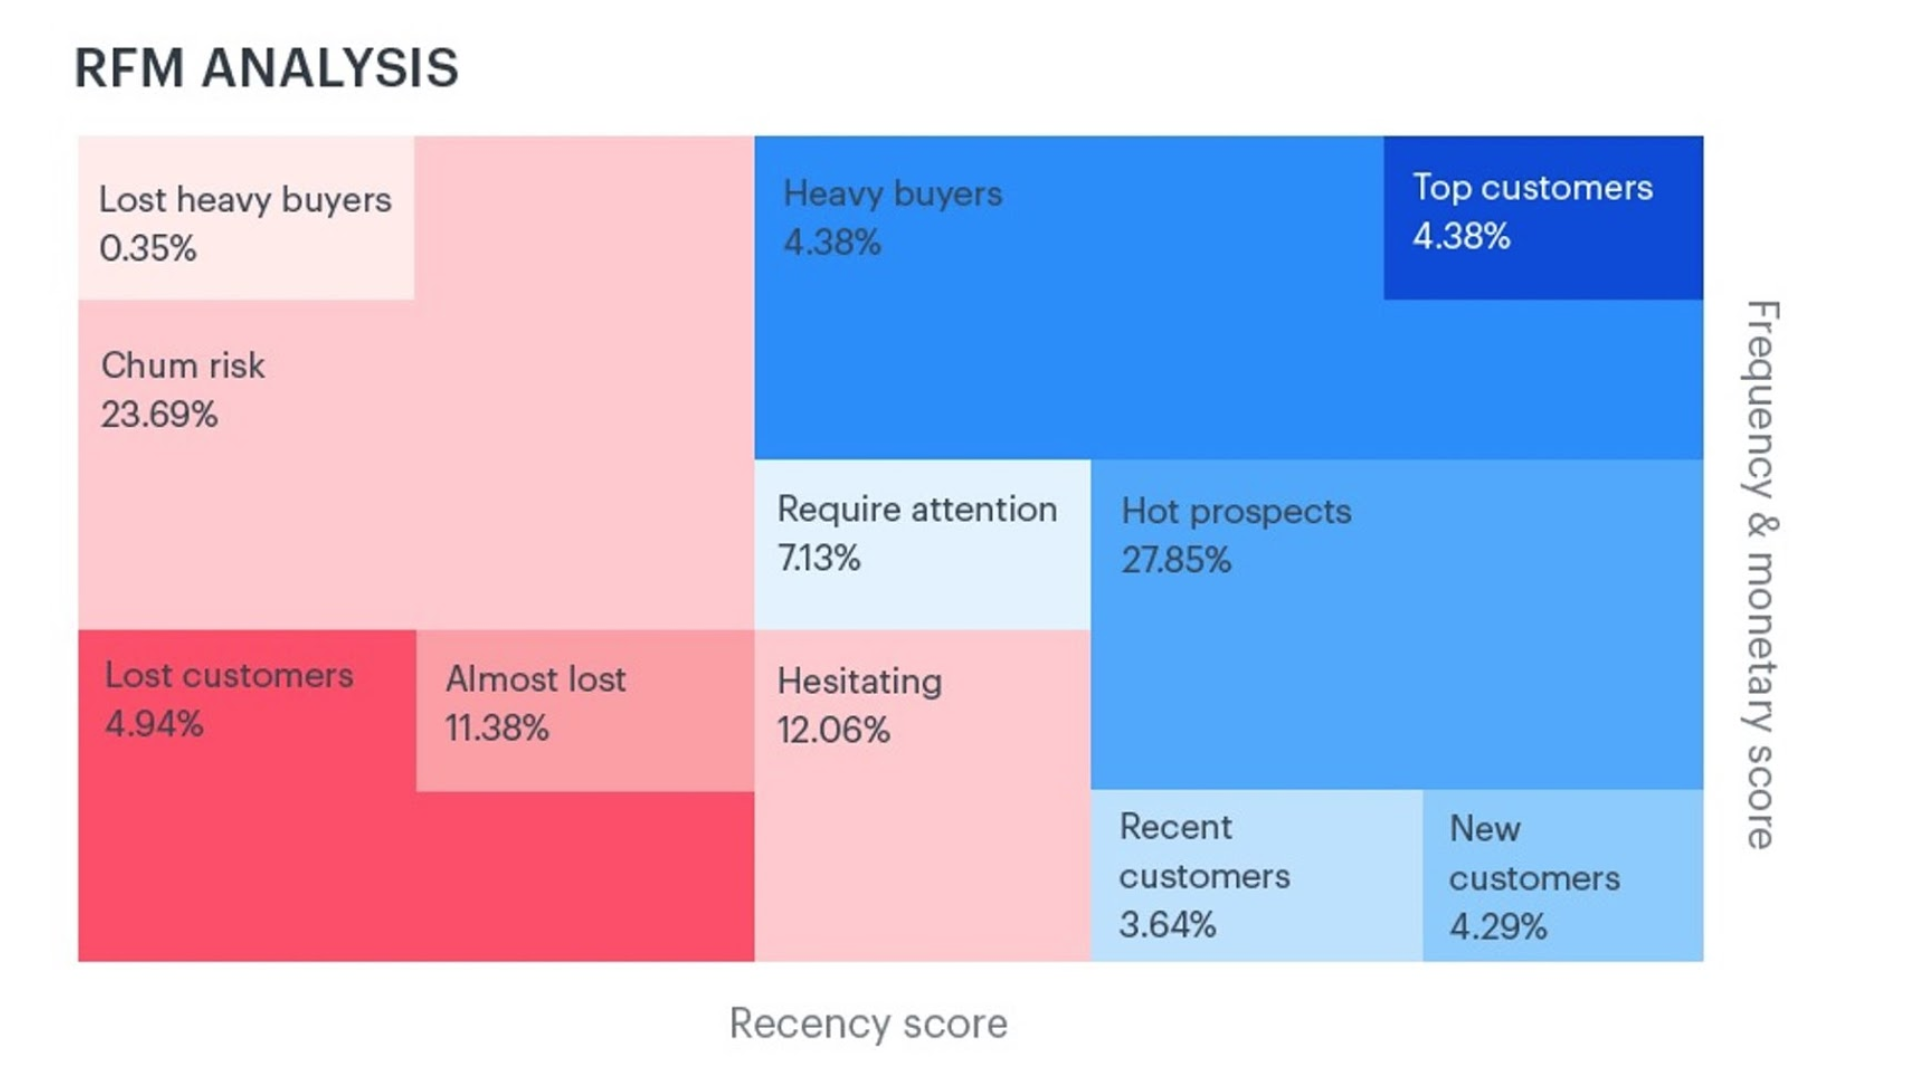

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

import umap.umap_ as umap

## Helper Functions

In [2]:
# Notebook configuration
display( HTML( '<style>.container { width:95% !important; }</style>') )

## Load Dataset

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='iso-8859-1')

# drop extra colum
df_raw = df_raw.drop(columns='Unnamed: 8')

# Data Cleaning & Data Description

In [4]:
# save pickle
pickle.dump(df_raw, open('../src/steps/df1.pkl', 'wb'))

# load pickle
df1 = pickle.load(open('../src/steps/df1.pkl', 'rb'))

## Rename Columns

In [5]:
# ordering columns
df1 = df1[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

# rename columns
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## Data Dimensions

In [6]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 541909
Number of Cols: 8


## Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### Drop NA

In [9]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print(f'Removed data: {(1 - (df1.shape[0] / df_raw.shape[0])) * 100:.2f}%')

Removed data: 24.93%


In [10]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## Change dtypes

In [11]:
# [invoice_date] - change from object to datetime format
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# [customer_id] - verify if there are float values in the column, if not, change the format to int64
if [print(i) for i in df1['customer_id'] if i.is_integer() == False] == []:
    df1['customer_id'] = df1['customer_id'].astype('int64')

## Descriptive Statistics

# Feature Engineering

In [12]:
# save pickle
pickle.dump(df1, open('../src/steps/df2.pkl', 'wb'))

# load pickle
df2 = pickle.load(open('../src/steps/df2.pkl', 'rb'))

## Feature Creation

In [13]:
# data reference
df_ref = pd.DataFrame(df2['customer_id']).drop_duplicates(ignore_index=True)

In [14]:
# Gross Revenue: quantity * unit_price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# calculate de total sell per customer
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# merge df_ref with df_monetary
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

In [15]:
# Recency: number of days since last purchase 

# obtain the last purchase date of each customer 
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# calculate the number of days since last purchase (use last purchase on dataset as 'today')
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days

# merge df_ref with recency days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
dtype: int64

In [16]:
# Frequency: how many products each customer purchased 

# obtain the quantity of purchase by customer
df_frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'})

# merge df_ref with frequency
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
frequency        0
dtype: int64

In [17]:
# Avg Ticket: mean of gross revenue for each customer
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})

# merge df_ref with avg ticket
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
frequency        0
avg_ticket       0
dtype: int64

In [18]:
df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# Data Filtering

In [19]:
# save pickle
pickle.dump(df_ref, open('../src/steps/df3.pkl', 'wb'))

# load pickle
df3 = pickle.load(open('../src/steps/df3.pkl', 'rb'))

# Exploratory Data Analysis

In [20]:
# save pickle
pickle.dump(df3, open('../src/steps/df4.pkl', 'wb'))

# load pickle
df4 = pickle.load(open('../src/steps/df4.pkl', 'rb'))

# Data Preparation

In [21]:
# save pickle
pickle.dump(df4, open('../src/steps/df5.pkl', 'wb'))

# load pickle
df5 = pickle.load(open('../src/steps/df5.pkl', 'rb'))

# Feature Selection

In [22]:
# save pickle
pickle.dump(df5, open('../src/steps/df6.pkl', 'wb'))

# load pickle
df6 = pickle.load(open('../src/steps/df6.pkl', 'rb'))

# Machine Learning

In [23]:
# save pickle
pickle.dump(df6, open('../src/steps/df7.pkl', 'wb'))

# load pickle
df7 = pickle.load(open('../src/steps/df7.pkl', 'rb'))

## Hyperparameter Fine Tuning

In [24]:
# remove customer id column
x = df7.drop(columns=['customer_id'])

In [25]:
clusters = [2, 3, 4, 5, 6, 7]

### Within-Cluster Sum of Square (WSS)

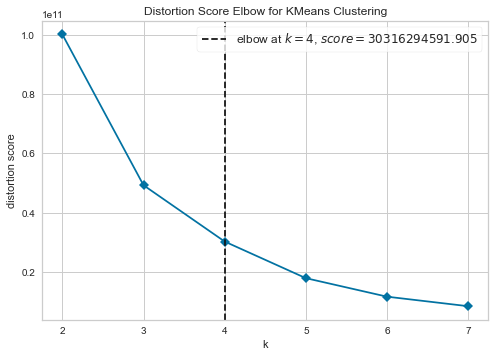

In [26]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(x)
kmeans.show();

### Silhouette Score

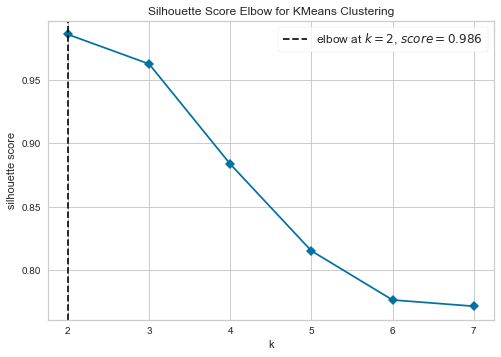

In [27]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(x)
kmeans.show();

### Silhouette Analysis

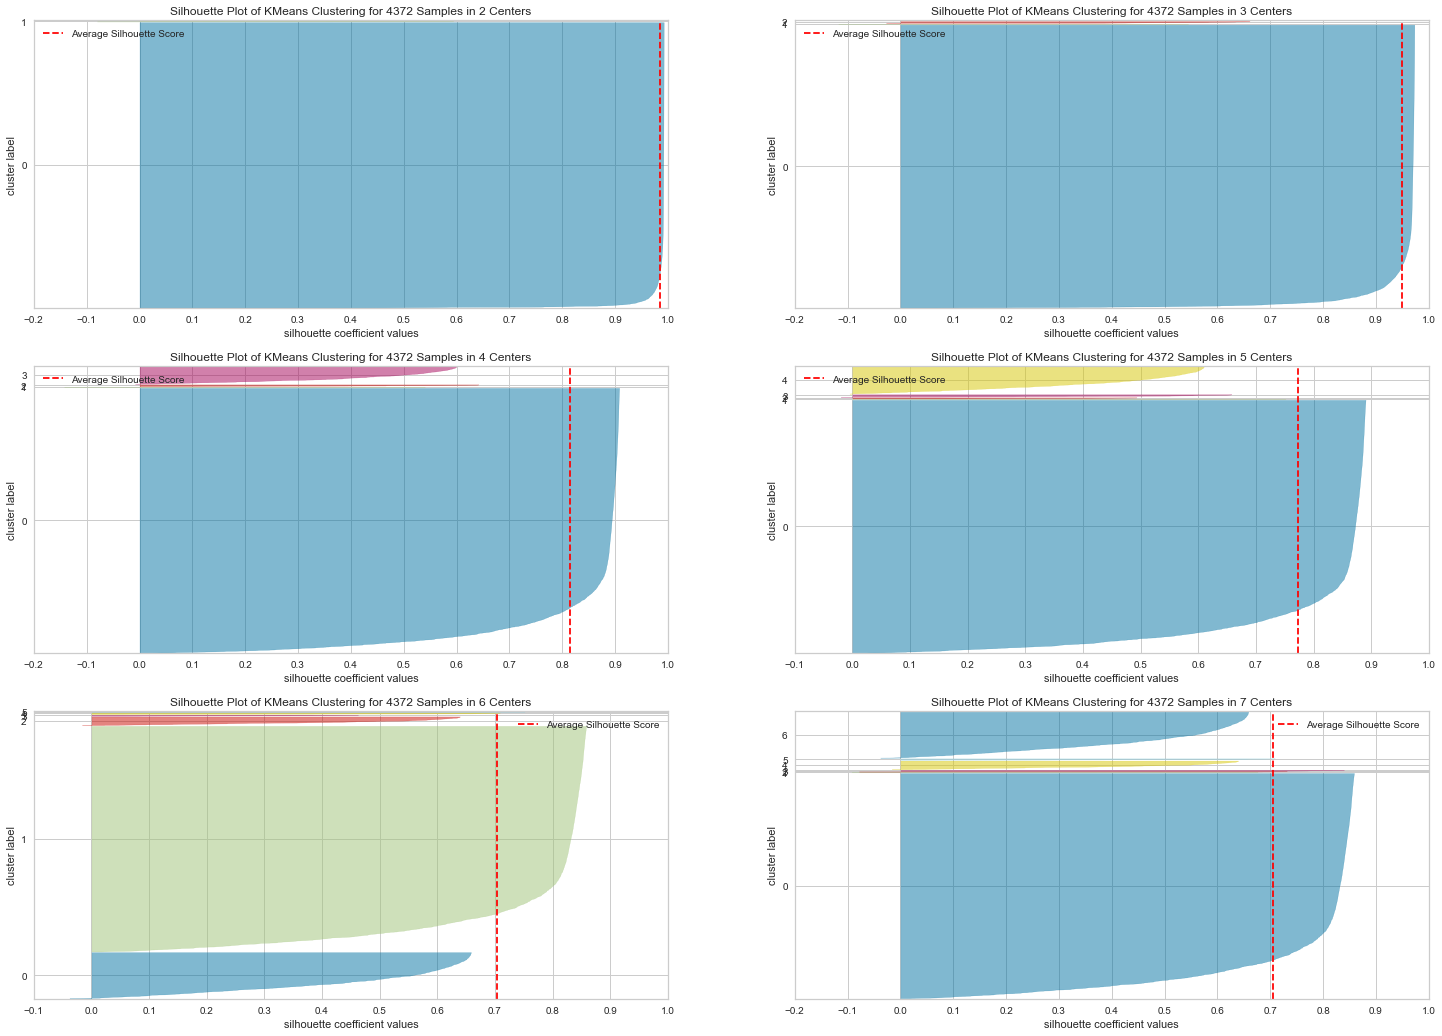

In [28]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(25, 18))
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(x);
    visualizer.finalize();

## Model Training

### K-Means

In [29]:
# model definition
k = 4
kmeans = c.KMeans(init = 'random',
                  n_clusters = k,
                  n_init = 10,
                  max_iter = 300,
                  random_state = 42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

#### Cluster Validation

In [30]:
# WSS
print(f'WSS value: {kmeans.inertia_}')

# SS
print(f'SS value: {m.silhouette_score(x, labels, metric="euclidean")}')

WSS value: 40056506734.60248
SS value: 0.8139972028952444


# Cluster Analysis

In [31]:
# save pickle
pickle.dump(df7, open('../src/steps/df8.pkl', 'wb'))

# load pickle
df8 = pickle.load(open('../src/steps/df8.pkl', 'rb'))

# add clustering labels
df8['cluster'] = labels

## Visualization Inspection

### Silhouette Score

c:\users\victo\repos\insiders_clustering\insiders-venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


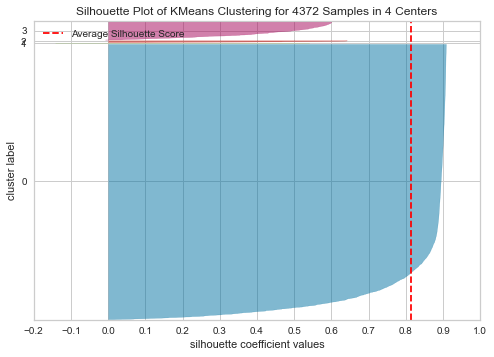

In [32]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(x)
visualizer.finalize();

### 2D Plot

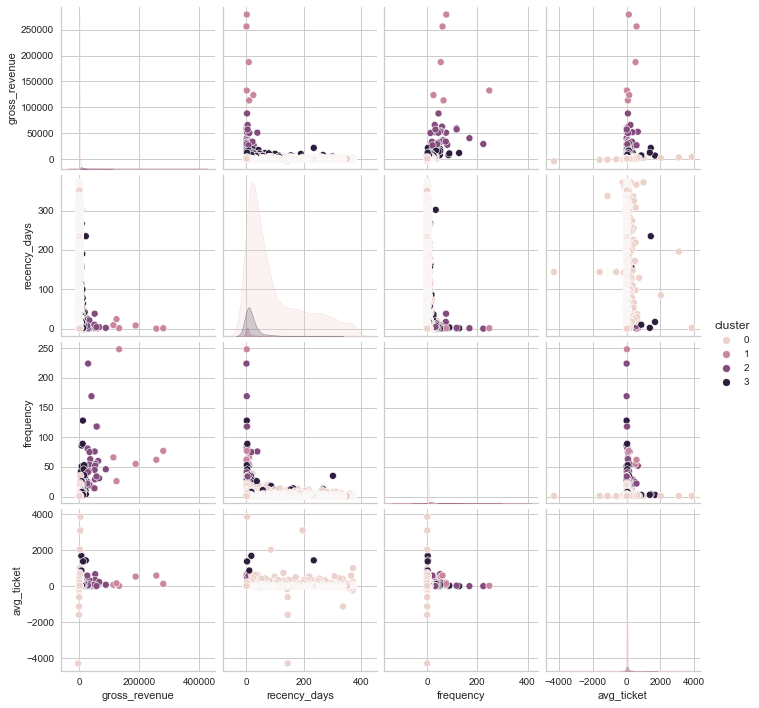

In [33]:
df_viz = df8.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

### UMAP

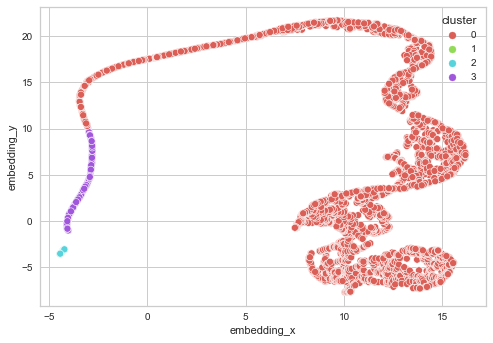

In [34]:
# instantiate UMAP
reducer = umap.UMAP(n_neighbors=20, random_state=42)

# transform data space into embedding
embedding = reducer.fit_transform(x)

# define x and y and save on df_viz dataset
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## Cluster Profile

In [35]:
# Number of customers
df_cluster = df8[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_gross_revenue = df8[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_recency_days = df8[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg Frequency
df_frequency = df8[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Avg TIcket
df_ticket = df8[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


###  Cluster 01:  ( Candidatos Insider )
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# Deploy